<hr style='height:3pt'>

# Meme Caption Generator

<hr style='height:3pt'>

In [13]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import LSTM, Embedding, TimeDistributed, RepeatVector, Activation, Flatten, Add, Dot, Concatenate
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import numpy as np
import pickle
import sys
import os
import cv2
from pickle_utils import pickle_load, pickle_dump
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Check GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Building Model Architecture

In [15]:
# load embeddings
embeddings, idx2word, word2idx, captions = pickle_load("full_clean_processed_data.pkl")
captions.image = captions.image.apply(lambda x: x.strip(' '))

In [16]:
# input parameters
img_shape = (300,300,3)
vocab_size = embeddings.shape[0]
embedding_size = 300
maxlen = 20                         # maximum length of the caption in hidden state
batch_size = 32
hidden_units = embedding_size       # length of word vectors i.e. embedding size

# hyper params
clip_norm = 1.0
learning_rate = 0.01
decay_rate = 0.7                    # for RMS Prop

In [17]:
def build_model_attn(img_shape, vocab_size, embedding_size, maxlen, hidden_units, clip_norm, 
                     learning_rate, decay_rate = decay_rate):
    '''
    =============
      ENCODER
    =============
    Inputs: 
        1. Image (,300, 300, 3)
        2. Tokenized label (,30)

    Model:
        3. Pretrained CNN with classification layer peeled off
              - Output of InceptionV3: (2048,)
              - Add layer of size 300
              - Final output: (300,)
        4. LSTM with initial state as the output of CNN (300 dimensional)
              - Input is the tokenized padded label
              - Uses embedding matrix
              - Set embedding matrix to trainable
    '''

    # 1. Image Input
    input_img = keras.Input(shape=img_shape, name='image_input')

    # 2. Label Embedding
    input_label = keras.Input(shape=(maxlen,), name='image_label_input')

    # 3. Define Pretrained CNN - Inception V3
    cnnModel_incomplete = InceptionV3(weights='imagenet', 
                           include_top=False,        # this removes the final dense layer
                           input_shape=img_shape, 
                           pooling = 'avg')

    # freeze all convolutional InceptionV3 layers
    for layer in cnnModel_incomplete.layers:
        layer.trainable = False

    # Get image embedding <- this is a model output
    image_emb = cnnModel_incomplete(input_img)

    # MLP with 300 nodes to get output of image model
    image_emb_reduced = Dense(300, activation='relu')(image_emb)

    # Define CNN model
    cnnModel = keras.Model(inputs=input_img, outputs=image_emb_reduced)

    '''
    =============
      ENCODER
    =============
        4. Embedding layer that uses the GloVe embedding matrix, and is set to be trainable
              - Output size: (20, 300) 

        5. LSTM with initial state as the output of CNN (300 dimensional)
              - Input is the tokenized padded label
              - Uses embedding matrix
              - Set embedding matrix to trainable
    '''

    # 10. Embedding layer
    encoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                  input_length=maxlen, embeddings_regularizer = None,
                                  weights = [embeddings], name = 'label_embeddings', 
                                  trainable = True, mask_zero=True)
    # 11. LSTM for image label

    # Prepare input for the LSTM hidden state and/or cell state
    initial_state_LSTM_label = cnnModel(input_img)
    encoder_LSTM = LSTM(hidden_units, return_sequences=True, return_state=True)

    ## ===== Get embedding and LSTM outputs =====
    encoder_embedding_outputs = encoder_embedding(input_label)
    encoder_LSTM_outputs, hidden_state_encoder, cell_state_encoder = encoder_LSTM(
                                                            encoder_embedding_outputs, 
                                                            initial_state = [initial_state_LSTM_label,  # hidden state
                                                                            initial_state_LSTM_label]) # cell state

    encoder = keras.Model(inputs=[input_img, input_label], outputs=encoder_LSTM_outputs)

    '''
    =============
      DECODER
    =============
    Inputs: 
        8. Caption (tokenized) (20,) <- limiting caption length to 20
        9. LSTM hidden state from encoder

    Model:
        10. Embedding layer that uses the GloVe embedding matrix, and is set to be trainable
              - Output size: (20, 300)
        11. LSTM
              -  Output size: (20, 300)
        12. Time Distributed layer to apply Dense layer to all the time step outputs
              - Output size: (20, 40000)
        13. Activation of softmax to get values between 0 and 1
              - Output size: (20, 40000)
    '''

    # 8. Caption
    input_caption = keras.Input(shape = (maxlen,), name='image_caption_input')

    # 9. Input for the LSTM hidden state and/or cell state
    # initial_state_LSTM = encoder([input_img, label_emb])

    # 10. Embedding layer
    decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_size,
                                  input_length=maxlen, embeddings_regularizer = None,
                                  weights = [embeddings], name = 'caption_embeddings', 
                                  trainable = True, mask_zero=True)
    # 11. LSTM
    decoder_LSTM = LSTM(hidden_units, return_sequences=True, return_state=True)

    ## ===== Get embedding and LSTM outputs =====
    decoder_embedding_outputs = decoder_embedding(input_caption)
    decoder_LSTM_outputs, _ , _ = decoder_LSTM(decoder_embedding_outputs, 
                                          initial_state = [hidden_state_encoder,  # hidden state
                                                           cell_state_encoder])   # cell state

    #ATTENTION
    attention = Dot(axes = [2,2])([encoder_LSTM_outputs, decoder_LSTM_outputs])
    attention = Activation('softmax')(attention)
    context = Dot(axes = [2,1])([attention, encoder_LSTM_outputs])
    decoder_combined_context = Concatenate()([context, decoder_LSTM_outputs])

    #time distributed layer, probability predictions for all unique words
    decoder_time_distributed = TimeDistributed(Dense(vocab_size, name = 'decoder_timedistributed'))
    decoder_activation = Activation('softmax', name = 'decoder_activation')
    decoder_outputs = decoder_activation(decoder_time_distributed(decoder_combined_context))

    '''
    ==============
      FULL MODEL
    ==============   
    '''

    model= Model(inputs=[input_img, input_label, input_caption], outputs=decoder_outputs)
    rmsprop = RMSprop(lr=learning_rate, clipnorm=clip_norm, decay=decay_rate)
    model.compile(loss='categorical_crossentropy', optimizer=rmsprop)

    print(model.summary())
    
    return model

In [18]:
meme_model = build_model_attn(img_shape, vocab_size, embedding_size, maxlen, hidden_units, clip_norm, learning_rate)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_label_input (InputLayer)  (None, 20)           0                                            
__________________________________________________________________________________________________
image_input (InputLayer)        (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
label_embeddings (Embedding)    (None, 20, 300)      11012700    image_label_input[0][0]          
__________________________________________________________________________________________________
model_4 (Model)                 (None, 300)          22417484    image_input[0][0]                
__________________________________________________________________________________________________
image_capt

In [19]:
# Create dictionary of image data to store in cache
base_fp = os.getcwd() + '/../memes/'
image_dict = {}
for name, fp in zip(captions.image.unique(), captions.file_path.unique()):
    im = cv2.imread(base_fp + fp)
    assert im is not None # check that the image has been read correctly
    image_dict[name] = im

In [20]:
captions.head()

,image,above_text,below_text,file_path,full_caption,full_padded_caption,tokenized_label,tokenized_padded_label
0,y u no,kony,y u no take justin bieber,y-u-no.jpg,<sos> kony <break> y u no take justin bieber ...,"[1, 685, 2, 92, 72, 21, 166, 304, 446, 0, 0, 0...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,y u no,ted,y u no tell us how you met their mother,y-u-no.jpg,<sos> ted <break> y u no tell us how you met t...,"[1, 2522, 2, 92, 72, 21, 201, 245, 131, 5, 124...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,y u no,internet,y u no let me study,y-u-no.jpg,<sos> internet <break> y u no let me study ...,"[1, 250, 2, 92, 72, 21, 182, 15, 814, 0, 0, 0,...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,y u no,i held the door,y u no say thank you,y-u-no.jpg,<sos> i held the door <break> y u no say thank...,"[1, 3, 4844, 4, 800, 2, 92, 72, 21, 80, 1288, ...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,y u no,ugly girl y u play hard to get,when u already hard to want,y-u-no.jpg,<sos> ugly girl y u play hard to get <break> w...,"[1, 1515, 42, 92, 72, 129, 525, 7, 47, 2, 32, ...","[92, 72, 21]","[92, 72, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Data Generation

In [21]:
def data_gen(df, embeddings, word2idx, image_dict, batch_size=32, im_dim=(300, 300, 3)):
    '''
    Data generator
    
    Inputs:
        df - Pandas dataframe with caption information
        embeddings - matrix of embeddings to map from word indices
        word2idx - matrix to convert words to indices (for image labels)
        image_dict - dictionary containing the image pixel data, keys are labels
        
    Outputs: (batch of batch_size)
        images - batch of pre-processed images
        label_embs - batch of averaged image label embeddings
        caption_inds - batch of caption indices 
        targets - batch of sequences of one-hot encoded sparse vocab vectors 
        
    '''
    while 1:  # needed for keras generator
        # Shuffle data
        df_new = df.sample(frac=1).reset_index(drop=True)

        # Split into batches
        split_ind = list(range(0, df_new.shape[0], batch_size))
        batches = np.array_split(df_new, split_ind[1:])
        for i, batch in enumerate(batches):
            
            # Prepare matrices to hold data
            images = np.zeros((batch.shape[0], im_dim[0], im_dim[1], im_dim[2]))
            label_inds = np.zeros((batch.shape[0], maxlen))
            caption_inds = np.zeros((batch.shape[0], maxlen))
            targets = np.zeros((batch.shape[0], maxlen, vocab_size))
            
            for j, (_, row) in enumerate(batch.iterrows()):
                ### Prepare Image Data ###
                im_data = image_dict[row.image]  # get image data for batch
                
                if im_data.shape != im_dim:  # resize if not 300 x 300
                    im_data = cv2.resize(im_data, (im_dim[0], im_dim[1])) 
                    
                im_data = im_data/255  # normalize
                im_data = im_data.astype(np.float32)  # convert to single-precision
                images[j] = im_data  # save the image
                
                ### Prepare Image Labels ###
                label_inds[j] = row.tokenized_padded_label
                
                ### Prepare Caption Indices ###
                caption_ind = row.full_padded_caption
                caption_inds[j] = caption_ind 
                
                ### Prepare Target ###
                target_ind = caption_ind[1:]  # target index is right shifted version of caption
                #target_ind.append(1)  # add an extra eos
                target_ind.append(0)  # add an extra eos
                target = to_categorical(target_ind, num_classes=vocab_size)  # matrix of max_len x vocab size
                targets[j] = target
                
                
            yield [images, label_inds, caption_inds], targets

In [ ]:
# Early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=2, patience=0)

In [ ]:
history = meme_model.fit_generator(data_gen(captions, embeddings, word2idx, image_dict, batch_size=32), 
                        steps_per_epoch=np.ceil(captions.shape[0]//batch_size), 
                        epochs=10,
                        verbose=1, 
                        callbacks=[es])

Epoch 1/10
2191/2191 [==============================] - 1308s 597ms/step - loss: 6.2558
Epoch 2/10
1681/2191 [======================>.......] - ETA: 5:01 - loss: 6.1277

In [13]:
# Save model if good
meme_model.save('meme_model_lstm_attn_decay.h5')

<hr style='height:3pt'>

# Inference

<hr style='height:3pt'>

In [55]:
def inference(model, image, im_label, idx2word, greedy=True, k=3):
    '''
    Takes model predicted probabilities and converts to text
    
    inputs:
        preds - vector of probability distributions over vocabulary
        image - base image to predict for
        im_label - image label associated with the base image (string)
        idx2word - map of indices to words
        
    outputs:
        caption - predicted caption text
    '''
    # preprocessing
    image = np.expand_dims(image, axis=0)
    im_label = np.expand_dims(imlabel_to_token(im_label, word2idx), axis=0)
    caption = np.zeros((1, 20))
    result = []
    
    for i in range(maxlen):
        # make a prediction
        preds = model.predict([image, im_label, caption])
        
        if greedy:  # implement greedy search
            ind = np.argmax(preds[0, i])
            
        else:  # implement beam search
            top_k_idx = np.argsort(preds[0, i])[-k:]
            #ind = np.random.choice(top_k_idx) # unweighted
            weights = sorted(preds[0, i])[-k:]
            norm_weights = weights/np.sum(weights)
            ind = np.random.choice(top_k_idx, p=norm_weights)
            
        caption[0, i] = ind
        result.append(idx2word[ind])
    return result

    
def imlabel_to_token(label, word2idx):
    '''
    Converts an image label to its average embedding
    '''
    words = label.split(' ')
    word_inds = [word2idx[word] for word in words]
    word_inds.extend([0]*(maxlen - len(word_inds)))
    return word_inds

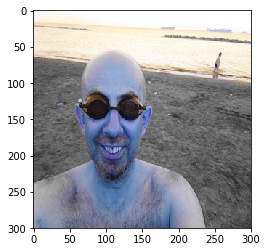

man at beach


['one',
 '<break>',
 "can't",
 'stop',
 'looking',
 'for',
 'the',
 'people',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>',
 '<eos>']

In [60]:
import matplotlib.pyplot as plt
#meme_model.load('meme_model_v1') # load model

filepath = os.getcwd() + '/../base_images/pavlos.png'
pred_image = cv2.imread(filepath) # pavlos
assert pred_image is not None  # make sure image gets read in
# pred_image = list(image_dict.values())[90]
pred_image = cv2.resize(pred_image, (300, 300))
plt.imshow(pred_image)
plt.show()

im_label = input()
inference(meme_model, pred_image, im_label, idx2word, greedy=True, k=5)

In [31]:
filepath = os.getcwd() + '/../base_images/abhi_example_input.jpg'
pred_image = cv2.imread(filepath) # pavlos
pred_image = cv2.resize(pred_image, (300, 300))



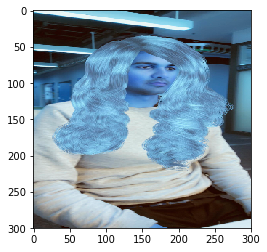

In [32]:
plt.imshow(pred_image)

In [27]:
list(image_dict.keys())[90]

'rage fu'

In [64]:
captions.iloc[np.where(captions.full_caption.isna())[0]]

,image,above_text,below_text,file_path,full_caption,full_padded_caption,tokenized_label
602,yo dawg,yo dawg we heard u liek sopa,so we burned your house,yo-dawg.jpg,NaN,"[1, 77, 95, 57, 142, 42, 3103, 730, 2, 40, 57,...","[77, 95]"
625,yo dawg,yo dawg i heard you like little girls,so i called the police.,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 543, 120, 2, 40, 4,...","[77, 95]"
639,yo dawg,yo dawg i heard that you liked batman,so i killed your parents,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 25, 3, 991, 1251, 2, 40, 4...","[77, 95]"
645,yo dawg,yo dawg i heard you like macs,so we took all the windows out your car,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 2286, 2, 40, 57, 33...","[77, 95]"
662,yo dawg,yo dawg i heard you like fastfood,so i put a rocket in your whopper.,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 3888, 2, 40, 4, 315...","[77, 95]"
702,yo dawg,yo dawg i heard you like batman,so we killed your parents,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 1251, 2, 40, 57, 53...","[77, 95]"
707,yo dawg,yo dawg i heard you like yu-gi-oh,so we glued your dog to a card,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 8825, 2, 40, 57, 76...","[77, 95]"
725,yo dawg,,wtf do you mean you don't like strategic bombing?,yo-dawg.jpg,NaN,"[1, 2, 936, 50, 3, 152, 3, 35, 26, 16559, 1656...","[77, 95]"
735,yo dawg,yo dawg i heard you like csi,so i kill your kids,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 8832, 2, 40, 4, 75,...","[77, 95]"
746,yo dawg,yo dawg i heard you like chicks,so we filled your house with eggs,yo-dawg.jpg,NaN,"[1, 77, 95, 4, 142, 3, 26, 1661, 2, 40, 57, 19...","[77, 95]"
